# **The MNIST Dataset: Building a Deep Neural Network Classifier from scratch**

For more information, check out the following link:

https://www.youtube.com/watch?v=HMcx-zY8JSg&t=548s&ab_channel=HvassLaboratories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import math

tf.__version__

'2.3.0'

### Importing the dataset

In [2]:
data = tf.keras.datasets.mnist.load_data(path='mnist.npz')
print('Data is set as tuple of numpy arrays: (x_train, y_train), (x_test, y_test)')
(x_train, y_train), (x_test, y_test) = data
print('- With training-set:')
print('x_train has dimensions {} corresponding to # of images the images\'shape' .format(x_train.shape))
print('y_train has dimensions {} corresponding to the labels'.format(y_train.shape[0]))
print('- With testing-set:')
print('x_test has dimensions {} corresponding to # of images the images\'shape' .format(x_test.shape))
print('y_test has dimensions {} corresponding to the labels'.format(y_test.shape[0]))

11493376/11490434 [==============================] - 0s 0us/step
Data is set as tuple of numpy arrays: (x_train, y_train), (x_test, y_test)
- With training-set:
x_train has dimensions (60000, 28, 28) corresponding to # of images the images'shape
y_train has dimensions 60000 corresponding to the labels
- With testing-set:
x_test has dimensions (10000, 28, 28) corresponding to # of images the images'shape
y_test has dimensions 10000 corresponding to the labels


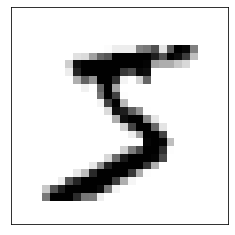

Target value: 5


In [3]:
pixels = data[0][0][0]
plt.imshow(pixels.astype('uint8'), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.show()
print('Target value:', data[0][1][0])

Let's get a couple parameters about our data set:

In [20]:
#shape of images (i.e. number of pixels)
img_shape = np.shape(data[0][0][0])

#channel per pixels (1 channel for grey-scale)
num_channels = 1

#number of classes: the digits running from 0 to 9
num_classes = 10

# **Preparing up the Model**

- placeholders
- helper functions
- the architecture of the neural network, the weights and the ouputs
- optimizing the cost-function


### **Placeholders**

We define placeholder variables; these include the input and the ouput of the computational graph in TensorFlow. 
- We start with the input images x, which we convert to a 4-dim array x_image, expected for the inputs of each layer.
- We also account for the output y_true, a 1D array of 10 entries, each corresponding to a class. Finally y_true_clas which returns the argmax of y_true

In [15]:
# Version 2.3.0 of tf comes with eager execution enabled by default. We must disable it before proceeding
tf.disable_eager_execution()
x = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]], name='x')
x_image = tf.reshape(x, [-1, img_shape[0], img_shape[1], num_channels])

In [16]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

### **Helper-Functions**

These allow us to create new variables and to define the shape of the **convulational neural network**. Importantly enough, we define for future use functions for:
- the weights and the biases of the network
- the convolutional layers
- the fully-connected layers

In [60]:
def new_weights(shape):
  return tf.Variable(tf.truncated_normal(shape, mean = 0,  stddev=0.5))

def new_biases(length):
  return tf.Variable(tf.constant(0.05, shape=[length]))

Each **convolutional layer** is defined by the **input** images and the **filters**. Specifically, each layer inputs a 4-dimensional tensor described by:
- the number of images
- dimension 1 of each image
- dimension 2 of each image
- the number of channels

And the filters are described:
- the number of filters
- the shape of the filters

In [63]:
def conv_layer(input,               # Outputs from the previous layer: must account for num. of channels as well
               filters,             # The filters of the layer: must account num. of filters and their shape
               use_pooling=True):   # Use 2x2 max-pooling to reduce image resolution
    
    num_input_channels = input.shape[-1]
    filter_size = filters[0]        # the shape of the filters, assuming it is square
    num_filters = filters[1]        # the number of filters

    # Create new weights and new biases from the filters-weights for the convolution.
    # The weights are stored in a 4D array corresponding the shape of the filters, the number of channels and the number of filters
    weights = new_weights(shape=[filter_size, filter_size, num_input_channels, num_filters])
    # # The biases correspond only to filters
    biases = new_biases(length=num_filters)

    # The layer, with the biases. Strides indicate we move 1 image, 1 pixel (down and right) and 1 channel at a time
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases

    # If use_pooling true, let's down-sample the image resolution. ksize indicates which max value to take
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

In [29]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat

A **fully connected layer** only needs the input images and the number of outputs. Remember that for a fully connected layer $L$, there are $N_L$ neurons:

$\mathbf{x}^{L} = \mathbf{W}^L \mathbf{x}^{L-1} + \mathbf{b}^L$
and $\mathbf{x}^{L} = h(\mathbf{x}^{L})$ where:
- $\mathbf{x}^{L}$ in the space of $\mathbb{R}^{N_L}$
- $\mathbf{W}^L$ in the space of $\mathbb{R}^{N_L} \times \mathbb{R}^{N_L - 1}$
- $h$ is the activation function (ReLU for example)

For a **CNN**, the relationship above holds but the elements $\mathbf{x}^{L}$ and $\mathbf{W}^{L}$ are *4-dim tensors*.

In [31]:
def fc_layer(input,          # Outputs from the previous layer, must account for num. of inputs
             num_outputs,    # Num. of outputs
             use_relu=True): # Use Rectified Linear Unit by default

    num_inputs = input.shape[-1]

    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the new layer using simple matrix mulitplication
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### **The Neural Network Architecture**

It is made of two sequential convolutional layers, followed by two sequential fully-connected layers. A flatten layer is needed between the CNN's and the FC's. Let's use the following parameters:

In [26]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.
filters2 = (filter_size2, num_filters2)

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [68]:
layer_conv1, weights_conv1 = conv_layer(x_image, (filter_size1, num_filters1), use_pooling=True)

layer_conv2, weights_conv2 = conv_layer(layer_conv1, (filter_size2, num_filters2), use_pooling=True)

layer_flat = flatten_layer(layer_conv2)

layer_fc1 = fc_layer(layer_flat, fc_size, use_relu=True)

layer_fc2 = fc_layer(layer_fc1, num_classes, use_relu=False)

And **the results**

In [75]:
y_pred = tf.nn.softmax(layer_fc2)

y_pred_class = tf.argmax(y_pred, axis = 1)

### **Cost-function Optimization**

# **Running the Model**

fff